In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
import os

results_path = "/home/jason/Applications/omnetpp-6.0.1/samples/florasat/simulations/satellitewired/results"
sca_files = [f for f in os.listdir(results_path) if "N=" in f and f.endswith(".sca")]

dfs = []
for file in sca_files:
    os.system(f"opp_scavetool x {os.path.join(results_path, file)} -o {file}.csv")

    df = pd.read_csv(f"{file}.csv")
    dfs.append(df)

dfs.sort(key=lambda df: int(df.loc[df['name'] == 'nrOfNodes'].value.iloc[0]))

Exported 765 scalars, 2930 parameters, 68 histograms
Exported 1054 scalars, 4160 parameters, 118 histograms
Exported 1902 scalars, 7850 parameters, 268 histograms
Exported 1626 scalars, 6620 parameters, 218 histograms
Exported 1344 scalars, 5390 parameters, 168 histograms


In [3]:
def get_overhead_bytes(df):
    # Total bytes of overhead (Beacon, RTS, VCTS)
    total_num_rts_packets = df.loc[df['name'] == 'numRTSPacketsSent'].value.astype(int).sum()
    bits_per_rts_packet = int(df.loc[df['name'] == 'rtsPacketLengthBits'].value.iloc[0])
    rts_overhead_bytes = (total_num_rts_packets * bits_per_rts_packet) / 8

    total_num_vcts_packets = int(df.loc[df['name'] == 'numVCTSPacketsSent'].value.iloc[0])
    bits_per_vcts_packet = int(df.loc[df['name'] == 'vctsPacketLengthBits'].value.iloc[0])
    vcts_overhead_bytes = (total_num_vcts_packets * bits_per_vcts_packet) / 8

    total_num_beacon_packets = int(df.loc[df['name'] == 'numBeaconPacketsSent'].value.iloc[0])
    bits_per_beacon_packet = int(df.loc[df['name'] == 'beaconPacketLengthBits'].value.iloc[0])
    beacon_overhead_bytes = (total_num_beacon_packets * bits_per_beacon_packet) / 8

    overhead_bytes = rts_overhead_bytes + vcts_overhead_bytes + beacon_overhead_bytes
    
    return overhead_bytes

In [4]:
def get_throughput_bytes_per_second(df):
    # Throughput b / s
    sim_time_second = float(df.loc[df['name'] == 'simulated time'].value.iloc[0])
    bits_per_data_packet = int(df.loc[df['name'] == 'dataPacketLengthBits'].value.iloc[0])
    num_data_packets = int(df.loc[df['name'] == 'numDataPacketsReceived'].value.iloc[0])

    throughput_bits_per_second = (num_data_packets * bits_per_data_packet) / sim_time_second
    return throughput_bits_per_second

In [5]:
def get_throughput_kilobytes_per_hour(df):
    # Throughput kb / hr
    sim_time_hours = float(df.loc[df['name'] == 'simulated time'].value.iloc[0]) / 60 / 60
    kilobits_per_data_packet = int(df.loc[df['name'] == 'dataPacketLengthBits'].value.iloc[0]) / 1000
    num_data_packets = int(df.loc[df['name'] == 'numDataPacketsReceived'].value.iloc[0])

    throughput_kilobits_per_hour = (num_data_packets * kilobits_per_data_packet) / sim_time_hours
    return throughput_kilobits_per_hour

In [6]:
def get_jfi(df):
    # Jain's Fairness Index
    num_nodes = int(df.loc[df['name'] == 'nrOfNodes'].value.iloc[0])
    denominator = num_nodes * df[df['name'].str.startswith('numDataPacketsReceivedByNodeId', na=False)].value.astype(int).pow(2).sum()
    numerator =  df[df['name'].str.startswith('numDataPacketsReceivedByNodeId', na=False)].value.astype(int).sum() ** 2.0
    jfi = numerator / denominator if denominator != 0 else 0
    return jfi

In [19]:
node_count = []
jfis = []
throughputs_bytes_per_second = []

for df in dfs:
    node_count.append(int(df.loc[df['name'] == 'nrOfNodes'].value.iloc[0]))
    jfis.append(get_jfi(df))
    throughputs_bytes_per_second.append(get_throughput_bytes_per_second(df))

[0.7278195488721805, 0.741275167785235, 0.750354609929078, 0.6685185185185185, 0.4640677966101695]


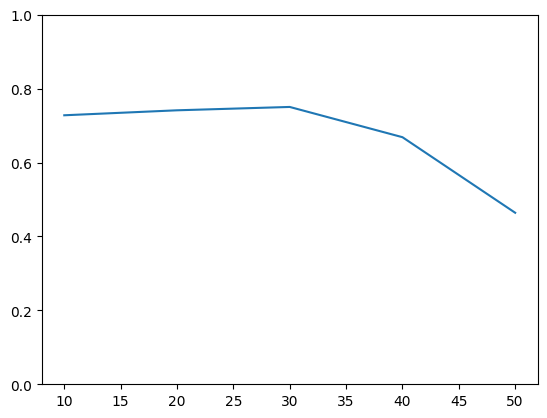

In [24]:
print(jfis)

plt.ylim(0, 1)
plt.plot(node_count, jfis)
plt.show()

[129.8659580497518, 138.9108566831793, 136.05810954304124, 112.18632829149969, 109.59375844702858]


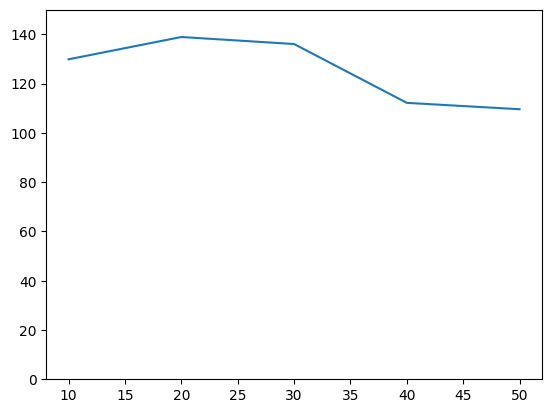

In [27]:
print(throughputs_bytes_per_second)

plt.ylim(0, 150)
plt.plot(node_count, throughputs_bytes_per_second)
plt.show()